# Lab 2: Network Intrusion Detection

In [64]:
# Imports
#from __future__ import print_function
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold


from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn.lda import LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

In [33]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] # 


# Remove the four duplicate rows with invalid value for is_ftp_login
df = df[df.is_ftp_login != 2]

## Data Preparation:

* Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [34]:
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print("duplicate record deleted successfully: " + str(len(df)) + " observations remaining") 
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
        
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print("[" + feature + "]" + "still found, check removal code. (Should not see this)" )       

duplicate record deleted successfully: 82328 observations remaining


In [35]:
# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers

# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print("Value error({0}): ".format(e))  # Note

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB


In [37]:
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

# determine if we have roughly the same percentage of  normal vs abnormal observations
# ref: http://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
# ref: http://www.gossamer-threads.com/lists/python/python/809232 (print percentage)
unique, counts = np.unique(y, return_counts=True)
uniqueClassCounts = dict(zip(unique, counts))    
totalObservations = len(y)
print(uniqueClassCounts)
print("Percent normal(0) is {0:.0%}".format(float(uniqueClassCounts[0])/totalObservations))
print("Percent attack(1) is {0:.0%}".format(float(uniqueClassCounts[1])/totalObservations))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 190 entries, dur to state_RST
dtypes: float64(162), int64(28)
memory usage: 120.0 MB
{0: 37000, 1: 45328}
Percent normal(0) is 45%
Percent attack(1) is 55%


ref:
(a) http://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation
(b) http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
(c) http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/


Per ref (a) stratification in general seeks to ensure each fold is representative of all strata in the data. The label feature has two classes (categories) as seen above normal(0) and attack(1) with percentages of 45% and 55%, respectively based on distribution of the classes with respect to the complete dataset. If it was 50%/50% one could argue a random sampling should create evenly distributed folds and with large enough sample size, should be sufficient. The main argument for stratification is to address the biasing effects of classification algorithms based on over/under representation of classes in any one particular sample or folds for classification algorithms that do not inherently have inherent balancing techniques either by selection or weighting.  According to ref (a), however, it does lead to a loss of diversity (unwanted loss of variance). Basically, the more unbalanced then the classes are, the more biased a classification algorithm in general would be to the observations tending to the more popular class. Stratification seeks to correct for that artificially to address algorithms that cleverly try and predict the class witht the highest weighting based on class distribution.

Since the values in the labels are not exactly equal, a stratified Kfold validation is recommended so that each set or fold contains approximately the same percentage of samples of each target class as the complete set.
Note: Will do both for comparision sake to see if there is any difference
in results and to get a feel for the methodology.

Note: per ref (a) To combat imbalanced training data, one technique woudl be to try and colect more data with a larger dataset.  However. since we did not generate this data ourselves, this would not be an option.

Another thing that we can do to to measure performance is to selecting the right set of performance metrics beyond the arguably defalt one which is accuracy.  

With our particular dataset there are a couple of different view points on which performance metrics a model should be tuned for for this particular dataset:
1) False negatives are probably worse than false positives. If a malicious packet gets through undetected, it could potentially do bad things without being noticed, whereas a false positive could be rescreened or reviewed to clear the packet. Note: however, if the system has protection in depth, perhaps down stream systems may catch the packet or some effect of the malicous abnormal packet (e.g. host based intrusion detection system, so it may not be that bad).
Recall may be a good metric to gauge model performance based on highlighting false negatives. Recall is defined as the number of True Postivies divided by the number of True Positives and the number of False Negatives, also known as Sensitivity or the True Postive Rate. 

2) However, if there are too may false positives, where the system over classifies packets as malcious when they really aren't then it could be interfering with normal operations and impact business operations. On the assumption that it takes some signficant amount of time to clear a tagged (false) positive packet. If a tool identifies too many false positives, people would lose trust with the system. Based on this view, precision which is defined as the number of True Positives divided by the number of True Positives and False positives would be a good metric to use to gauge performance of models used for predicting abnormal packets.

3) Based on these view points, a metric which combines both would be the F1 Score which is 2*((precision*recall)/(precision+recall)) also know as the F Score or F Measure which tries to convey the balance between precision and recall. 

In [38]:
# Lets go ahead and scale our features
# Need to see which models do better or actually need scaling. (e.g. does Logistic regression need indpendent variables scaled?)
# scaling isn't needed for Logistic regression per  http://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression

#from sklearn import preprocessing
#my_scaler = preprocessing.StandardScaler()
#my_scaler.fit(X[:, :X.shape[1]])
#my_scaler.transform(X[:, :X.shape[1]]).mean(axis=0)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
#ref : http://stackoverflow.com/questions/2866380/how-can-i-time-a-code-segment-for-testing-performance-with-pythons-timeit
import time
#ref: http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html
numObservations = len(dfcopy)
print(numObservations)
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

y = dfcopy['label'].values
numObservations = len(dfcopy)
num_folds = 10
kf = KFold(numObservations, n_folds=num_folds)
skf = StratifiedKFold(y, num_folds)

# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
print(kf)
t0 = time.clock()

for train_index, test_index in kf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0

accuracies = cross_val_score(lr_clf, X, y=y, cv=kf) # this also can help with parallelism
#print(accuracies)
print("Average Accuracy across " + str(num_folds) + " fold cross validation iterations = " + str(np.average(accuracies)) + " training time = " + str(total))    

t0 = time.clock()
for train_index, test_index in skf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# http://scikit-learn.org/stable/modules/model_evaluation.html
accuracies = cross_val_score(lr_clf, X, y=y, cv=skf) # this also can help with parallelism
precision = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='precision')
recall = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='recall')
accuracy = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='accuracy')
f1 = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='f1')# just testing to see if it is same as default
#print(accuracies)
#print "Percent normal(0) is {0:.0%}".format(float(classCounts[0])/totalObservations)
print("Average Accuracies across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%} ".format(np.average(accuracies)) + " training time = " + str(total))    
print("Average Precision across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(precision)) + " training time = " + str(total))    
print("Average Recall(Sensitivity) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(recall)) + " training time = " + str(total))    
print("Average Accuracy across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(accuracy)) + " training time = " + str(total))    
print("Average F measure(F1) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(f1)) + " training time = " + str(total))    

# http://stackoverflow.com/questions/23339523/sklearn-cross-validation-with-multiple-scores
from sklearn import metrics
def mean_scores(X, y, clf, skf):

    cm = np.zeros(len(np.unique(y)) ** 2)
    for i, (train, test) in enumerate(skf):
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        cm += metrics.confusion_matrix(y[test], y_pred).flatten()

    return compute_measures(*cm / skf.n_folds)

def compute_measures(tp, fp, fn, tn):
     """Computes effectiveness measures given a confusion matrix."""
     specificity = tn / (tn + fp)
     sensitivity = tp / (tp + fn)
     fmeasure = 2 * (specificity * sensitivity) / (specificity + sensitivity)
     return sensitivity, specificity, fmeasure
    
print(mean_scores(X, y, lr_clf, skf))

82328
sklearn.cross_validation.KFold(n=82328, n_folds=10, shuffle=False, random_state=None)
Average Accuracy across 10 fold cross validation iterations = 0.606487290653 training time = 10.3615818576
Average Accuracies across stratified 10 fold cross validation iterations = 75%  training time = 11.3754972735
Average Precision across stratified 10 fold cross validation iterations = 85% training time = 11.3754972735
Average Recall(Sensitivity) across stratified 10 fold cross validation iterations = 66% training time = 11.3754972735
Average Accuracy across stratified 10 fold cross validation iterations = 75% training time = 11.3754972735
Average F measure(F1) across stratified 10 fold cross validation iterations = 73% training time = 11.3754972735
(0.67579947052149436, 0.86077042667127313, 0.75715162668194602)


The stratified 10 fold cross validation appears to have a higher accuracy score of 75% vs 61%. Not much difference in computational expense between the two cross validation methods.
    # https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/
   
   Sensitivy/recall measures how good the model is at detecting the positives, which somewhat important.
However, 

In [46]:
# try and use K- Nearest neighbors

from sklearn.neighbors import KNeighborsClassifier 
estimator = KNeighborsClassifier()
estimator.fit(X_train, y_train)
y_predicted = estimator.predict(X_test)
accuracy = np.mean(y_test == y_predicted) * 100
print("The accuracy is {0:.1f}%".format(accuracy))

The accuracy is 66.9%


In [49]:
scores = cross_val_score(estimator, X, y, scoring='accuracy')
average_accuracy = np.mean(scores) * 100
print("The average accuracy is {0:.1f}%".format(average_accuracy))

The average accuracy is 76.9%


In [53]:
avg_scores = []
all_scores = []
parameter_values = list(range(1, 21))  # Include 20
for n_neighbors in parameter_values:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, X, y, scoring='accuracy')
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)

The slowest run took 84.78 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 743 µs per loop


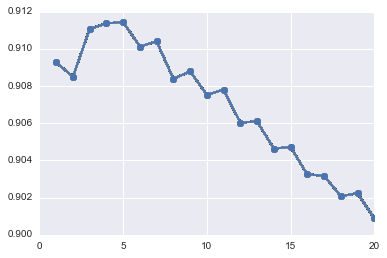

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt 
%timeit plt.plot(parameter_values, avg_scores, '-o')

Results of varing the n_neighbors parameter from 1-20.
There is relatively a lot of variance between 1-5, but then the variance decreases from 6-20. Also the accuracy peaks at n = 2 with a value of about 77.5%, but then decreases steadily to about 75% showing a decreasing trend. 

The slowest run took 39.75 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 754 µs per loop


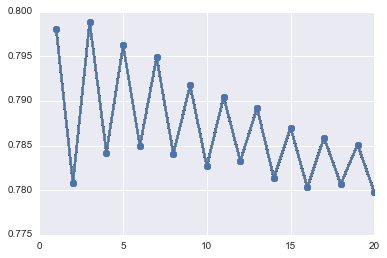

In [56]:
# Calculate f1 score as well for comparision 
avg_scores = []
all_scores = []
parameter_values = list(range(1, 21))  # Include 20
for n_neighbors in parameter_values:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, X, y, scoring='f1')
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)
%timeit plt.plot(parameter_values, avg_scores, '-o')

Using F1 scoring, the best score appears to be n_neighbors = 3 with a score close to 80%. There is a lot of variance overall, although it appears to have a slight decreasing trend as n_neighbors increases. Range though between 1-20 goes from near 80% to 78% which isn't that large. 

Lets attempt to normalize our data to see if that increases our accuracy and F1 Score

The slowest run took 38.85 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 741 µs per loop


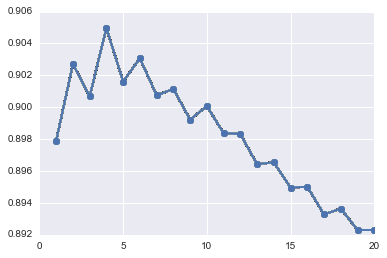

In [61]:
from sklearn.preprocessing import MinMaxScaler
X_transformed = MinMaxScaler().fit_transform(X)
avg_scores = []
all_scores = []
parameter_values = list(range(1, 21))  # Include 20
for n_neighbors in parameter_values:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, X_transformed, y, scoring='accuracy')
    avg_scores.append(np.mean(scores))
    all_scores.append(scores) 
%timeit plt.plot(parameter_values, avg_scores, '-o')

This took a long while to complete. at almost 1 second per .75s per loop, with 1000 loops, that is about 12.5 minutes. After normalization it appars that n_neighbors = 4 yields the best accuracy at about 90.5% with relatively large variation between 1-5 n_neighbors and then steadily decreasing variation down to 20.  The range in accuracy though is between 89.2 to 90.5% which is relatively small.  Lets do this again for F1 score.


The slowest run took 35.06 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 807 µs per loop


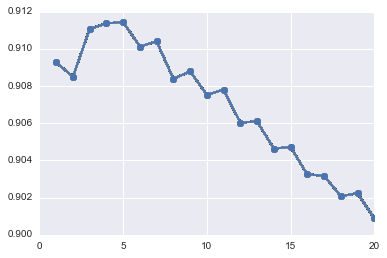

In [62]:
from sklearn.preprocessing import MinMaxScaler
X_transformed = MinMaxScaler().fit_transform(X)
avg_scores = []
all_scores = []
parameter_values = list(range(1, 21))  # Include 20
for n_neighbors in parameter_values:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, X_transformed, y, scoring='f1')
    avg_scores.append(np.mean(scores))
    all_scores.append(scores) 
%timeit plt.plot(parameter_values, avg_scores, '-o')

This took awhile to complete. Based on the plot, the best f1 socre is with n_neigbor = 5 with about 91.7%. There is some large variance between 1-3, and after 5, the f1 metric starts to steadily decrease with variance fairly constant.

Overall:

So using f1 as our best metric and kNearest neighbor as our model with n_neighor=5 is the best we can get to predict our chosen class variable using 191 features "kitchen sink". 

In [68]:
# Time the performance using 

from sklearn.preprocessing import MinMaxScaler
X_transformed = MinMaxScaler().fit_transform(X)
avg_scores = []
all_scores = []
parameter_values = list(range(1, 21))  # Include 20
t0 = time.clock()
for n_neighbors in parameter_values:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, X_transformed, y, scoring='f1')
    avg_scores.append(np.mean(scores))
    all_scores.append(scores) 
total = t1 - t0
print("Traing/plotting time in seconds = " + str(total))

Traing/plotting time in seconds = -45119.7063288


* Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [56]:
#ref: http://matthewrocklin.com/blog/work/2016/07/12/dask-learn-part-1

from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000,
                           n_features=500,
                           n_classes=2,
                           n_redundant=250,
                           random_state=42)

In [57]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('logistic', logistic)])


In [ ]:
#Parameters of pipelines can be set using ‘__’ separated parameter names:
grid = dict(pca__n_components=[50, 100, 250],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])

scores = ['precision', 'recall', 'f1', 'accuracy']

#grid = dict(pca__n_components=[50],
#            logistic__C=[1e-4],
#            logistic__penalty=['l2'])

In [70]:
from sklearn.grid_search import GridSearchCV
#from __future__ import print_function

for score in scores:
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, scoring='%s' % score)
    %time estimator.fit(X, y)
    print(score + " " + str(estimator.best_score_))


Wall time: 32.8 s
precision 0.89184751014
Wall time: 35.7 s
recall 0.8948
Wall time: 34.8 s
f1 0.893126414374
Wall time: 35.2 s
accuracy 0.8928


In [7]:
estimator.best_score_

0.8928

In [8]:
estimator.best_params_

{'logistic__C': 0.0001, 'logistic__penalty': 'l2', 'pca__n_components': 50}

In [55]:
# ref: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

#from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    # http://stackoverflow.com/questions/1614236/in-python-how-to-i-convert-all-items-in-a-list-to-floats
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in digits.target_names.tolist()]))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}

Grid scores on development set:

0.986 (+/-0.016) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.959 (+/-0.029) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.982 (+/-0.026) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.982 (+/-0.025) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.982 (+/-0.025) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 1}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 10}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 100}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model 

In [101]:
from sklearn.datasets import make_regression, make_classification 
X, y = make_regression()
from sklearn import dummy
dumdum = dummy.DummyRegressor()
dumdum.fit(X, y)

dumdum.predict(X)[:5]


In [110]:
predictors = [("mean", None), ("median", None),("constant", 10)]
for strategy, constant in predictors:
       dumdum = dummy.DummyRegressor(strategy=strategy, 
                constant=constant)
        
dumdum.fit(X, y)
print ("strategy: {}".format(strategy), ",".join(map(str, 
          dumdum.predict(X)[:5])))

strategy: constant 10.0,10.0,10.0,10.0,10.0


In [114]:
#from __future__ import print_function
import platform
print(platform.python_version())
predictors = [("constant", 0),
                  ("stratified", None),
                  ("uniform", None),
                  ("most_frequent", None)]
X, y = make_classification()
for strategy, constant in predictors:
       dumdum = dummy.DummyClassifier(strategy=strategy, 
                constant=constant)
       dumdum.fit(X, y)
       print("strategy: {}".format(strategy), ",".join(map(str, 
             dumdum.predict(X)[:5])))

2.7.12
strategy: constant 0,0,0,0,0
strategy: stratified 1,0,0,0,1
strategy: uniform 0,0,1,0,0
strategy: most_frequent 0,0,0,0,0


In [ ]:
## Modeling and Evaluation:
* Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

*  Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

In [ ]:
# Reference: 

*  Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! 

In [43]:
# Refence Learning Data Mining with Python (Book)
y_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

*  Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

* Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation. 

* Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Deployment:
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work:

In [ ]:
#Miscellanous Testing

In [11]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


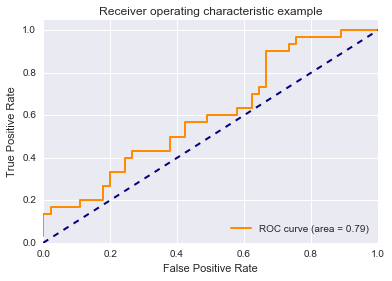

In [18]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [13]:
type(fpr[2])

numpy.ndarray

In [15]:
len(fpr[2])

33

In [17]:
len(tpr[1])

35